# TP1 : Parcours des protons dans la matière
### Physique Numérique (PHY-3500)
### Par: Simon Gauthier, Laurent Émond, Thomas Charland
### Présenté à: Xavier Roy-Pomerleau
### Remis le: 21 février 2025

## Mise en contexte

Le traitement de tumeurs cancéreuses se fait souvent par radiothérapie. La radiothérapie utilise des particules accélérées à très grande énergie pour causer du dommage localisé dans la tumeur cancereuse. La particule la plus souvent utilisée pour cela est le proton, et l'une des étapes initiales du traitement est de calculer l'énergie nécessaire de celui-ci afin de s'assurer de causer du dommage au bon endroit (la tumeur). 

Ce document résout le TP1 du cours de Physique Numérique (PHY-3500). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.integrate as integrate
import timeit
from pathlib import Path
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

plt.rcParams["font.size"] = 12

## Numéro 1

La densité électronique $n_e$ d'un composé de $M$ éléments est définie à partir de sa densité $\rho$ et sa composition d'atomes de numéro atomique $N_i$ présents avec une fraction massique de $f_i$ tel que:
$$
    n_e = \rho\sum_{n=1}^MN_if_i
$$

In [ ]:
def electronic_density(density, composition):
    """
    Calculate the electronic density of a compound.
    Params:
    density (float): The density of the compound in g/cm^3.
    composition (dict): A dictionary with the elements' atomic number as keys and a tuple 
        containing the massic fraction and the atomic mass in g/mol as values
    Returns:
    float: The electronic density of the compound in e-/cm^3.
    """
    avogadro = 6.022e23
    electronic_density = 0
    for z, (w, m) in composition.items():
        electronic_density += w * avogadro * z / m
    return electronic_density * density

In [ ]:
# from NIST for liquid water (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=276)
# the atomic masses are in u and come from: https://pubchem.ncbi.nlm.nih.gov/ptable/atomic-mass/
liquid_water_density = 1
liquid_water_composition = {1: (0.111894, 1.0080), 8: (0.888106, 15.999)} # {atomic number: (fraction, atomic mass)}
liquid_water_ne = electronic_density(liquid_water_density, liquid_water_composition)
print(f"La densité électronique de l'eau est de {liquid_water_ne:.2e} e-/cm^3.")

# from NIST for compact bone (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=119)
compact_bone_density = 1.85
compact_bone_composition = {
    1: (0.063984, 1.0080), 6: (0.278000, 12.011), 7: (0.027000, 14.007), 
    8: (0.410016, 15.999), 12: (0.002000, 24.305), 15: (0.070000, 30.9738), 16: (0.002000, 32.08), 20: (0.147000, 40.08)
    }
compact_bone_ne = electronic_density(compact_bone_density, compact_bone_composition)
print(f"La densité électronique de l'os compact est de {compact_bone_ne:.2e} e-/cm^3.")

## Numéro 2

Le pouvoir d'arrêt massique $S_{col, \rho}$ pour un composé est défini tel que:
$$
\begin{align*}
    S_{col, \rho} = \frac{S_{col}}{\rho} &= \frac{2\pi r_e^2m_ec^2n_e}{\rho\beta^2}\left[\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\beta^2\right]\\
    &= \frac{U}{\rho}\left[\frac{\gamma^2}{\gamma^2-1}\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\right]\\
\text{où } U=2\pi r_e^2m_ec^2n_e \text{ et } T_e^{max} \text{ est défini tel que:}\\
    T_e^{max} &= \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\left(\frac{m_e}{m_p}\right)+\left(\frac{m_e}{m_p}\right)^2}\\
\text{où } \gamma \text{ est défini tel que:}\\
    \gamma &= \frac{T}{m_pc^2}+1
\end{align*}
$$

In [ ]:
def massic_stopping_power(n_e, rho, T, I):
    """
    Calculate the massic stopping power of a material.
    Params: 
    n_e (float): The electronic density of the material in g/cm^3.
    rho (float): The density of the material in g/cm^3.
    T (float): The kinetic energy of the incident particle in MeV.
    I (float): The mean excitation energy of the material in MeV.
    Returns:
    float: The massic stopping power of the material in MeV cm^2/g.
    """
    c = 3e8 # speed of light in m/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511/c**2 # mass of the electron in MeV/c^2
    m_p = 938.272/c**2 # mass of the proton in MeV/c^2

    gamma = T / (m_p * c**2) + 1
    T_e_max = (2 * m_e * c**2 * (gamma**2 - 1)) / (1 + 2 * gamma * (m_e / m_p) + (m_e / m_p)**2)
    U = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    S_col_rho = (U / rho) * ((gamma**2 / (gamma**2 - 1)) * np.log((2 * m_e * c**2 * (gamma**2 - 1) * T_e_max) / I**2) - 2)
    return S_col_rho

In [ ]:
T = np.linspace(3, 250, 1000) # array of energies of the incident particle in MeV

liquid_water_I = 75e-6 # ionization energy of liquid water in MeV (see NIST reference above)

massic_stopping_power_water = massic_stopping_power(liquid_water_ne, liquid_water_density, T, liquid_water_I)

compact_bone_I = 91.9e-6 # ionization energy of compact bone in MeV (see NIST reference above)

massic_stopping_power_bone = massic_stopping_power(compact_bone_ne, compact_bone_density, T, compact_bone_I)

In [ ]:
plt.plot(T, massic_stopping_power_water, label="Eau liquide")  
plt.plot(T, massic_stopping_power_bone, label="Os compact")
plt.yscale("log")
plt.xlabel("Énergie (MeV)")
plt.ylabel(r"Pouvoir d'arrêt massique (MeV/g/cm$^2$)")
plt.legend()
plt.title("Pouvoir d'arrêt massique de l'eau liquide et de l'os compact")
plt.show()

## Numéro 3

Lorsqu’un proton entre en collision avec la matière, deux principaux phénomènes entraînent sa décélération. Ces phénomènes sont les interactions nucléaires et les interactions radiatives. Les interactions nucléaires correspondent aux interactions entre les protons incidents et les noyaux présents dans la matière. Quant aux interactions radiatives, elles se produisent entre les protons incidents et les électrons du milieu.

Le NIST fournit une base de données identifiant l’ampleur de ces interactions individuelles. Voici ces interactions représentées dans un même graphique.

In [ ]:
def read_pstar_data(filename):
    """
    Reads a text file and saves the data into a NumPy array.
    
    Parameters:
        filename (str): Path to the text file.
    
    Returns:
        np.ndarray: NumPy array containing the data.
    """
    try:
        path = os.getcwd() / Path("data") / Path(filename)
        data = np.loadtxt(path, delimiter=",", dtype=float, skiprows=8, usecols=(0, 1, 2, 3, 4, 5))
        return data
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
class Medium:
    """ A class to represent a medium with stopping power data. """
    def __init__(self, data):
        """ Initialize the Medium object with the stopping power data. """
        self.data = data
        self.nuclear_stoping_power = self.get_nuclear_stoping_power()
        self.electronic_stoping_power = self.get_electronic_stoping_power()
        self.total_stoping_power = self.get_total_stoping_power()

    def get_electronic_stoping_power(self):
        """ 
        Get the electronic stopping power data. 

        Returns:
            np.ndarray: NumPy array with the electronic stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 1]))
    
    def get_nuclear_stoping_power(self):
        """
        Get the nuclear stopping power data.

        Returns:
            np.ndarray: NumPy array with the nuclear stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 2]))
    
    def get_total_stoping_power(self):
        """
        Get the total stopping power data.

        Returns:
            np.ndarray: NumPy array with the total stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 3]))
    
    def graph_all_stoping_power(self, title="Pouvoir d'arrêt"):
        """ Graph the electronic, nuclear, and total stopping power. """
        plt.plot(self.nuclear_stoping_power[:,0], self.nuclear_stoping_power[:,1], label="Pouvoir d'arrêt dû au noyau")
        plt.plot(self.electronic_stoping_power[:,0], self.electronic_stoping_power[:,1], label="Pouvoir d'arrêt dû aux électrons")
        plt.plot(self.total_stoping_power[:,0], self.total_stoping_power[:,1], label="Pouvoir d'arrêt total", linestyle="--")
        plt.xlabel("Énergie (MeV)")
        plt.ylabel(r"Pouvoir d'arrêt (MeV cm$^2$/g)")
        plt.yscale("log")
        plt.title(title)
        plt.legend()
        plt.show()
        

In [ ]:
water = Medium(read_pstar_data("waterLiquidStoppingPower.txt"))
water.graph_all_stoping_power(title="Pouvoir d'arrêt de l'eau liquide")

bone = Medium(read_pstar_data("boneLiquidStoppingPower.txt"))
bone.graph_all_stoping_power(title="Pouvoir d'arrêt de l'os compact")


On remarque que le pouvoir d'arrêt dû au noyau est très petit (d'un facteur 1000) par rapport à celui dû aux électrons. Il est donc correct de négliger cette intéraction pour la suite des calculs.

## Numéro 4

Plus le pouvoir d'arrêt d'un matériel est grand, plus la portée de la particule sera faible dans le matériel. Il est donc logique et intuitif de dire que la portée suit une tendance inverse au pouvoir d'arrêt. 

Il est également possible de démontrer cela en utilisant les unités. Nous cherchons une portée (unités: cm, dimension: $L$) à partir du pouvoir d'arrêt (unités: MeV/cm, dimensions: $ML/T^2$) et de l'énergie (unités: MeV, dimensions: $ML^2/T^2$). Notre seul moyen d'obtenir la dimension adéquate pour la portée est de multiplier les dimensions de l'énergie par les dimensions de l'inverse du pouvoir d'arrêt : $ML^2/T^2 \cdot (ML/T^2)^{-1} = L$.

C'est exactement ce que nous retrouvons pour la formule de la portée CSDA: $R_{CSDA} = \int_0^{T_i} \frac{1}{S} dT$

## Numéro 5

La formule pour le pouvoir d'arrêt est relativement complexe, et nous nous retrouvons avec une intégrale de forme $\int \frac{1}{ln(T)+B} dT$, où B est une constante. Cette intégrale ne produit pas de solution analytique, et donc l'utilisation d'une méthode numérique est nécessaire.  

## Numéro 6

Avant de concevoir les deux algorithmes d'intégration demandés dans la question, établissons une équation qui exprime la relation entre la distance parcourue par l’électron dans le milieu, son énergie initiale et les caractéristiques du milieu. Nous définirons également une seconde fonction permettant de formater des tableaux de données en fonction du nombre de tranches demandées.

In [ ]:
def total_stopping_power(T, n_e, I):
    """
    Calculate the massic stopping power of a material.
    Params: 
    n_e (float): The electronic density of the material in g/cm^3.
    rho (float): The density of the material in g/cm^3.
    T (float): The kinetic energy of the incident particle in MeV.
    I (float): The mean excitation energy of the material in MeV.
    Returns:
    float: The massic stopping power of the material in MeV cm^2/g.
    """
    c = 3e8 # speed of light in m/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511/c**2 # mass of the electron in MeV/c^2
    m_p = 938.272/c**2 # mass of the proton in MeV/c^2

    gamma = T / (m_p * c**2) + 1
    T_e_max = (2 * m_e * c**2 * (gamma**2 - 1)) / (1 + 2 * gamma * (m_e / m_p) + (m_e / m_p)**2)
    U = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    S_col = (U ) * ((gamma**2 / (gamma**2 - 1)) * np.log((2 * m_e * c**2 * (gamma**2 - 1) * T_e_max) / I**2) - 2)
    return S_col

def stopping_power_array(a, b, n_slice, n_e, I):
    X = np.linspace(a, b, n_slice+1)
    Y = total_stopping_power(X, n_e, I)
    return X,Y

Nous allons commencer par mettre en place l'algorithme d'intégration en utilisant la méthode des trapèzes, qui permet d'approximer l'aire sous une courbe en divisant l'intervalle en plusieurs trapèzes de même largeur.

In [ ]:
def trapezoidal_integration(x, y):
    """ 
    Perform trapezoidal integration on the data.

    Parameters:
        x (np.ndarray): NumPy array with the x values.
        y (np.ndarray): NumPy array with the y values.

    Returns:
        float: The integral of the data.
    """
        
    # We set gobal variable for result
    integral = 0

    for i in range(len(x) - 1):
        # Calculate high of the trapezoid
        h = x[i+1] - x[i]
        # Calculate area of the trapezoid
        integral += (y[i] + y[i+1]) * h / 2
        
    return integral

In [ ]:
electron_energy = 150

water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, 1000, liquid_water_ne, liquid_water_I)
bone_x_total_stopping_power, bone_y_total_stopping_power = stopping_power_array(3, electron_energy, 1000, compact_bone_ne, compact_bone_I)

# calculate the range of the proton in water and bone
proton_range_water = trapezoidal_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1)
proton_range_bone = trapezoidal_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1)

# We print the results
print("Résultats pour la méthode des trapèzes:")
print("Valeur calculée de la portée du proton ayant une énergie de {:.1f} MeV dans l'eau liquide: {:.6f} cm".format(electron_energy, proton_range_water))
print("Valeur calculée de la portée du proton ayant une énergie de {:.1f} MeV dans l'os compact: {:.6f} cm".format(electron_energy, proton_range_bone))

Ensuite, nous poursuivrons avec la méthode de Romberg, qui améliore la précision de l'intégration en combinant les résultats obtenus avec la méthode des trapèzes grâce à une extrapolation raffinée.

In [ ]:
def romberg_integration(x, y, min_err = 0):
    """
    Perform Romberg integration on the data.
    x : x values (np.array of size (n,))
    y : y values (np.array of size (n,))
    min_err : minimum error for the Romberg method (float)
    n_slice : number of slices for the trapezoidal integration (int)

    Returns:
    float: The integral of the data.
    """
    # We find the number of points
    m = len(x)
    # 2**max_step == m
    max_step = int(np.log(m) / np.log(2))

    # We initialize an array in which we will store the results of the extrapolation
    romberg_array = np.zeros((max_step, max_step))
    
    # We fill the first column with trapezoidal integration results
    for i in range(max_step, 0, -1):
        # Step size
        step = 2**i
        # Indices of the points used
        indices = np.arange(0, m + 1, step)
        # We calculate the trapezoidal integration
        romberg_array[max_step - i, 0] = trapezoidal_integration(x[indices], y[indices])

    # We apply the Romberg method to extrapolate the results
    for j in range(1, max_step):
        for i in range(1, max_step):
            if (i >= j):
                # We apply the Romberg method
                romberg_array[i, j] = (4**j * romberg_array[i, j-1] - romberg_array[i-1, j-1]) / (4**j - 1)
            if (i == j) and (i > 0):
                # We check if the error is smaller than the minimum error
                if (abs(romberg_array[i, j] - romberg_array[i, j-1]) <= min_err):
                    print(f"Error smaller than the minimum error with {2**i} slices")
                    return romberg_array[i, j]

    # We return the result of the last extrapolation
    return romberg_array[max_step-1, max_step-1]

In [ ]:
# We set minimal error tolerance
minimal_error = np.finfo(float).eps

# We calculate the proton range in water and bone
proton_range_water = romberg_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1, minimal_error)

# We calculate the proton range in bone
proton_range_bone = romberg_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1, minimal_error)

# We print the results
print("Résultats pour la méthode de Romberg:")
print("Valeur calculée de la portée du proton ayant une énergie de {:.2f} MeV dans l'eau liquide: {:.6f} cm".format(electron_energy, proton_range_water))
print("Valeur calculée de la portée du proton ayant une énergie de {:.2f} MeV dans l'os compact: {:.6f} cm".format(electron_energy, proton_range_bone))

On remarque que les portées calculées sont très similaires d'une méthode à l'autre, ce qui nous indique les deux techniques sembnlent bien implantées.

Nous allons maintenant déterminer le nombre de tranches nécessaires afin que l'erreur d'approximation de la méthode utilisée atteigne la précision de la machine. Pour ce faire, nous calculons l'erreur d'approximation pour un certain nombre de tranche et nous la comparons à l'erreur machine. Lors que l'erreur d'approximation est inférieur à l'erreur machine, nous obtenons le nombre de tranche optimale aliant vitesse de calcul et précision. 

Pour la méthode des trapèzes, nous utilisons l'équation suivante pour déterminer l'erreur d'approximation pour un nombre de tranche 2**i : 
$$ \epsilon = \frac{1}{3} \left( I_i - I_{i-1}\right) $$

In [ ]:
# Nous définissons une erreur machine
err_machine = np.finfo(float).eps
last_result = 0
# Trapezoidal integration methode
for i in range(5, 25):
    N = 2**i
    # We calculate the integration with the trapezoidal method
    water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, N, liquid_water_ne, liquid_water_I)
    result = trapezoidal_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1)
    # We calculate the error using the equation above
    err = abs(result - last_result)/3
    last_result = result
    print(f"Erreur approcximative pour {N} tranches = {err}")
    # We check if the error is smaller than the machine error
    if err < err_machine:
        print(f"Résultat de la méthode des trapèzes pour N = {N}: {result:.6f} cm avec une erreur de {err:.2e}")
        break

Notre méthode ne semble pas atteindre la précision de la machine. Nous pensons que la fonction générant notre ensemble de données pourrait ne pas être constante. Une irrégularité dans cette fonction pourrait être à l'origine de cette divergence, compromettant ainsi la précision obtenue.

Maintenant, nous passons à l'algorythme de Roomberg. Pour Rommberg, il suffit simplement de modifier la fonction. La nouvelle fonction calcul l'erreur d'approximation pour 2^i tranches avant de passer à 2^i+1 tranches. Lorsque l'erreur d'approximation est inférieur à l'erreur machine, nous arrêtons le calcul. L'erreur d'approximation est calculé à l'aide de l'équation suivant : 
$$ \epsilon = \frac{1}{4^m-1} \left(R_{i,m} - R_{i-1,m}\right) $$
Dans cette équation, m représente le nombre de terme calculés et i représente le nombre de tranche tel que 2^i.



In [ ]:
def romberg_integration_estimated_N(x, y, min_err = 0):
    """
    Perform Romberg integration on the data.
    x : x values (np.array of size (n,))
    y : y values (np.array of size (n,))
    min_err : minimum error for the Romberg method (float)
    n_slice : number of slices for the trapezoidal integration (int)

    Returns:
    float: The integral of the data.
    """
    # We find the number of points
    m = len(x)
    # 2**max_step == m
    max_step = int(np.log(m) / np.log(2))

    # We initialize an array in which we will store the results of the extrapolation
    romberg_array = np.zeros((max_step, max_step))
    
    # We fill the first column with trapezoidal integration results
    for i in range(max_step, 0, -1):
        # Step size
        step = 2**i
        # Indices of the points used
        indices = np.arange(0, m + 1, step)
        # We calculate the trapezoidal integration
        romberg_array[max_step - i, 0] = trapezoidal_integration(x[indices], y[indices])

    # We apply the Romberg method to extrapolate the results
    for j in range(1, max_step):
        for i in range(1, max_step):
            if (i >= j):
                # We apply the Romberg method
                romberg_array[i, j] = (4**j * romberg_array[i, j-1] - romberg_array[i-1, j-1]) / (4**j - 1)
            if (i == j) and (i > 2):
                # We calculate the approximation error
                err_approx = abs((romberg_array[i, j-1] - romberg_array[i-1, j-1]) / (4**(j-1) - 1))
                # We check if the error is smaller than the minimum error
                if (err_approx <= min_err):
                    print(f"Erreur plus petite que l'erreur minimale avec {2**i} tranches")
                    return err_approx


    # We return the result of the last extrapolation
    return err_approx

In [ ]:
err_machine = np.finfo(float).eps
water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, 1000000, liquid_water_ne, liquid_water_I)
romberg_integration_estimated_N(water_x_total_stopping_power, water_y_total_stopping_power**-1, err_machine)

## Numéro 7

Ce numéro regroupe tous les calculs effectués précédemment en un seul graphique. Ce graphique présente les résultats des intégrations obtenus à l’aide de la méthode de Romberg et de la méthode des trapèzes en fonction du nombre de tranches utilisées. Il inclut également l’erreur d’approximation calculée pour chaque méthode en fonction du nombre de tranches. Ces erreurs sont déterminées à l’aide des équations décrites dans le numéro précédent.

In [ ]:
# Due to our sample rate we are stuck with those slices number (powers of 2)
n_slice_selection = [16, 32, 64, 128, 256, 512]

# We initialize the results arrays
water_integration_results_trapezoidal = []
water_integration_results_romberg = []
bone_integration_results_trapezoidal = []
bone_integration_results_romberg = []

# We initialize the errors arrays
error_water_integration_results_trapezoidal = []
error_water_integration_results_romberg = []
error_bone_integration_results_trapezoidal = []
error_bone_integration_results_romberg = []

# We calculate the proton range in water and bone for different number of slices and add the results to the lists
for n_slice in n_slice_selection:
    
    water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, n_slice, liquid_water_ne, liquid_water_I)
    bone_x_total_stopping_power, bone_y_total_stopping_power = stopping_power_array(3, electron_energy, n_slice, compact_bone_ne, compact_bone_I)

    # Trapezoidal integration for water
    water_integration_results_trapezoidal.append(trapezoidal_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1))
    # Trapezoidal integration for bone
    bone_integration_results_trapezoidal.append(trapezoidal_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1))

    # Romberg integration for water
    water_integration_results_romberg.append(romberg_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1))
    # Romberg integration for bone
    bone_integration_results_romberg.append(romberg_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1))

    # Romebrg error for water
    error_water_integration_results_romberg.append(romberg_integration_estimated_N(water_x_total_stopping_power, water_y_total_stopping_power**-1))
    # Romebrg error for bone
    error_bone_integration_results_romberg.append(romberg_integration_estimated_N(bone_x_total_stopping_power, bone_y_total_stopping_power**-1))

last_value_water_romberg = water_integration_results_romberg[0]
last_value_bone_romberg = bone_integration_results_romberg[0]

for i in range(1,len(n_slice_selection)):
    error_water_integration_results_trapezoidal.append(np.abs(water_integration_results_trapezoidal[i] - water_integration_results_trapezoidal[i-1])/3)
    error_bone_integration_results_trapezoidal.append(np.abs(bone_integration_results_trapezoidal[i] - bone_integration_results_trapezoidal[i-1])/3)

# Create the figure and primary axis
fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True)
# Plot the first line (Left Y-axis)
ax[0].plot(n_slice_selection, water_integration_results_trapezoidal, label="Eau liquide - Trapèzes", color="orange", linestyle="-")
ax[0].plot(n_slice_selection, water_integration_results_romberg, label="Eau liquide - Romberg", color="green", linestyle="-")
ax[0].set_ylabel("Portée (cm) - Eau liquide")
ax[0].legend()
ax[0].title.set_text("Portée selon le nombre de tranches")

ax_error_water = ax[0].twinx()
ax_error_water.plot(n_slice_selection[1:], error_water_integration_results_trapezoidal, label="Eau liquide - Erreur (trapèzes)", color="orange", linestyle="--")
ax_error_water.plot(n_slice_selection, error_water_integration_results_romberg, label="Eau liquide - Erreur (Romberg)", color="green", linestyle="--")
ax_error_water.set_ylabel("Erreur (cm)")
ax_error_water.legend()
ax_error_water.set_yscale("log")


# Create secondary axis (Right Y-axis)
ax[1].plot(n_slice_selection, bone_integration_results_trapezoidal, label="Os compact - Trapèzes", color="orange", linestyle="-")
ax[1].plot(n_slice_selection, bone_integration_results_romberg, label="Os compact - Romberg", color="green", linestyle="-")
ax[1].set_ylabel("Portée (cm) - Os compact")
ax[1].set_xlabel("Nombre de tranches d'intégration")
ax[1].legend()

ax_error_bone = ax[1].twinx()
ax_error_bone.plot(n_slice_selection[1:], error_bone_integration_results_trapezoidal, label="Os compact - Erreur (trapèzes)", color="orange", linestyle="--")
ax_error_bone.plot(n_slice_selection, error_bone_integration_results_romberg, label="Os compact - Erreur (Romberg)", color="green", linestyle="--")
ax_error_bone.set_ylabel("Erreur (cm)")
ax_error_bone.legend()
ax_error_bone.set_yscale("log")

print(f"Erreur d'approximation pour l'os (Romberg) avec {n_slice_selection[-2]} tranches : " + str(error_bone_integration_results_romberg[-2]))
print(f"Erreur d'approximation pour l'eau (Romberg) avec {n_slice_selection[-2]} tranches : " + str(error_water_integration_results_romberg[-2]))
print(f"Erreur d'approximation pour l'os (Trapèzes) avec {n_slice_selection[-2]} tranches : " + str(error_bone_integration_results_trapezoidal[-2]))
print(f"Erreur d'approximation pour l'eau (Trapèzes) avec {n_slice_selection[-2]} tranches : " + str(error_water_integration_results_trapezoidal[-2]))

plt.tight_layout()
plt.show()

## Numéro 8

Nous allons dériver à la main l'expression. Nous cherchons donc la solution de l'expression suivante:
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = \frac{d}{dT}\left(2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2}\left[\ln(\frac{2m_ec^2\beta^2\gamma^2T_e^{max}}{I^2}-2\beta^2)\right]\right)
\end{align*}$$
En utilisant $U=2\pi r_e^2 m_e c^2 n_e$ et $a=2m_ec^2$, nous simplifions en combinant des paramètres qui ne dépendent pas de T:
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = U\frac{d}{dT}\left( \frac{1}{\beta^2}\left[\ln(\frac{a\beta^2\gamma^2T_e^{max}}{I^2}-2\beta^2)\right]\right)
\end{align*}$$
En remplaçant $T_e^{max} = \frac{a(\gamma^2-1)}{b+\delta\gamma}$, et subséquemment en utilisant $k=\frac{a^2}{I^2}$, nous avons:
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = U\frac{d}{dT}\left( \frac{1}{\beta^2}\left[\ln\left(\frac{k\beta^2\gamma^2(\gamma^2-1)}{(b+\delta\gamma)}-2\beta^2\right)\right]\right)
\end{align*}$$
On exprime ensuite tout en fonction de $\gamma$:
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = U\frac{d}{dT}\left( \frac{\gamma^2}{\gamma^2 - 1}\left[\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)\right]\right)
\end{align*}$$
Puisque $\gamma$ est une fonction de $T$, on peut dériver l'expression ci-haut par rapport à $\gamma$ et multiplier par la dérivée de $\gamma$ par rapport à $T$ (dérivée en chaine):
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = U\left[\frac{d}{d\gamma}\left( \frac{\gamma^2}{\gamma^2 - 1}\left[\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)\right]\right) \cdot \frac{d\gamma}{dT}\right]
\end{align*}$$
On évalue donc la dérivée:
$$\begin{align*}
\frac{d}{dT}S_{col}(T) = U\frac{d\gamma}{dT}\cdot\left(-\frac{2\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)+\frac{3\delta\gamma^7+4b\gamma^6-6\delta\gamma^5-8b\gamma^4+7\delta\gamma^3+8b\gamma^2+4\delta\gamma-4b}{\gamma^3(\gamma+1)^2(\gamma-1)^2(b+\delta\gamma)}\cdot\frac{\gamma^2}{\gamma^2-1}\right)
\end{align*}$$
On dérive ensuite $\gamma$ selon $T$ et on obtient l'expression finale de la dérivée $S'_{col}(T)$:
$$\begin{align*}
S'_{col}(T) = \frac{U}{m_pc^2}\cdot\left(-\frac{2\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)+\frac{3\delta\gamma^7+4b\gamma^6-6\delta\gamma^5-8b\gamma^4+7\delta\gamma^3+8b\gamma^2+4\delta\gamma-4b}{\gamma^3(\gamma+1)^2(\gamma-1)^2(b+\delta\gamma)}\cdot\frac{\gamma^2}{\gamma^2-1}\right)
\end{align*}$$
où $\gamma=\frac{T}{m_pc^2}+1$, $U=2\pi r_e^2 m_e c^2 n_e$, $k=\frac{(2m_ec^2)^2}{I^2}$, $b=1+\left(\frac{m_e}{m_p}\right)^2$ et $\delta=\frac{2m_e}{m_p}$.

Finalement, on veut la dérivée $\frac{d}{dT}\left(\frac{1}{S(T)}\right)$. On peut donc utiliser le résultat précédant et le fait que:
$$\begin{align*}
\frac{d}{dx}\left(\frac{1}{f(x)}\right)=\frac{-f'(x)}{(f(x))^2}
\end{align*}$$
On a donc:
$$\begin{align*}
\frac{d}{dT}\left(\frac{1}{S_{col}(T)}\right) = \frac{-S'_{col}(T)}{(S_{col}(T))^2}
\end{align*}$$

In [ ]:
def derivative(T, n_e, I):
    """
    Calculate the derivative of the stopping power of a material.
    Params:
    T (np.ndarray): The kinetic energy of the incident particle in MeV.
    n_e (float): The electronic density of the material in e-/cm^3.
    I (float): The mean excitation energy of the material in MeV.
    Returns:
    np.ndarray: The derivative of the stopping power of the material in MeV cm^2/g.
    """
    
    c = 3e8 # speed of light in m/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511/c**2 # mass of the electron in MeV/c^2
    m_p = 938.272/c**2 # mass of the proton in MeV/c^2
    
    y = T/(m_p*c**2) + 1
    U = 2*np.pi*r_e**2*m_e*c**2*n_e
    k = (2*m_e*c**2)**2/I**2
    b = 1 + (m_e/m_p)**2
    d = 2*m_e/m_p

    num = y**2/(y**2-1)*(3*d*y**7+4*b*y**6-6*d*y**5-8*b*y**4+7*d*y**3+8*b*y**2+4*d*y-4*b)
    den = y**3*(y+1)**2*(y-1)**2*(b+d*y)

    log = np.log(k*(y**2-1)**2/(b+d*y)-2*(y**2-1)/y**2)

    dSdT = U/(m_p*c**2)*(-2*y/(y**2-1)**2*log + num/den)

    return -dSdT/(total_stopping_power(T, n_e, I))**2


## Numéro 9

Maintenant que nous avons une expression pour $f'(x)=\frac{d}{dT}\left(\frac{1}{S_{col}(T)}\right)$, il est possible de trouver l'erreur analytique d'approximation $\epsilon$ causée par la la méthode des trapèzes lors de l'intégration d'une fonction $f(x)$ tel que:
$$
\epsilon = \frac{1}{12}h^2(f'(a) - f'(b))
$$
où $a$ et $b$ sont les bornes d'intégration et $h$ est la largeur des tranches choisie.

In [ ]:
a = 3 # MeV
b = 150 # MeV

n_slice = 256

h = (b - a) / n_slice

error_water = 1/12*h**2*(derivative(a, liquid_water_ne, liquid_water_I) - derivative(b, liquid_water_ne, liquid_water_I))

error_bone = 1/12*h**2*(derivative(a, compact_bone_ne, compact_bone_I) - derivative(b, compact_bone_ne, compact_bone_I))

On peut ensuite comparer les erreurs pratiques (estimées à partir des résultats de l'intégration numérique) aux erreurs déterminée de manière analytiques en dérivant l'expression à intégrer. La tableau suivant inclut également les portées mesurées pour cahcune des deux méthodes:

|            | Portée (cm) |              | Erreur pratique (cm) |         | Erreur analytique (cm) |
|------------|-------------|--------------|----------------------|---------|------------------------|
|            | Trapèzes    | Romberg      | Trapèzes             | Romberg | Trapèzes               |
| Eau        | 15.753576   | 15.753602210 | 3.6E-05              | 3.4E-10 | 4.8E-05                |
| Os compact | 9.159924    | 9.159946072  | 2.1E-05              | 2.0E-10 | 2.8E-05                |

## Numéro 10

In [ ]:
energy_dist = stats.moyal(loc=150, scale=4) # energy distribution

n = 10000 # number of particles

energies = energy_dist.rvs(n) # array of energies

plt.hist(energies, bins=100)
plt.xlabel("Energie (MeV)")
plt.ylabel("Occurences (-)")
plt.title("Distribution d'énergie des protons")
plt.show()

## Numéro 11

In [ ]:
# use timeit to integrate the energies with the trapezoidal method, the tomberg method and the scipy.quad method

def inverse_stopping_power(T, n_e, I):
    return total_stopping_power(T, n_e, I)**-1


def wrapper_own(func, n_slice):
    for energy in energies:
        x_total_stopping_power, y_total_stopping_power = stopping_power_array(3, energy, n_slice, liquid_water_ne, liquid_water_I)
        # We show that results are very similar
        if energy == energies[-1]:
            print("Résultat pour une énergie de {:.2f} MeV: {:.7f} cm".format(energy, func(x_total_stopping_power, y_total_stopping_power**-1)))
        else:
            func(x_total_stopping_power, y_total_stopping_power**-1)

def wrapper_scipy(func):
    for energy in energies:
        # We show that results are very similar
        if energy == energies[-1]:
            print("Résultat pour une énergie de {:.2f} MeV: {:.7f} cm".format(energy, func(inverse_stopping_power, 3, energy, args = (liquid_water_ne, liquid_water_I))[0]))
        else : 
            func(inverse_stopping_power, 3, energy, args = (liquid_water_ne, liquid_water_I))

print("Méthode des trapèzes : ")
time_own_trapezoidal = timeit.timeit(lambda: wrapper_own(trapezoidal_integration, 6000), number=1)
print(f"Temps requis: {time_own_trapezoidal:.2f} s.")
print("\n")
print("Méthode de Romberg : ")
time_own_romberg = timeit.timeit(lambda: wrapper_own(romberg_integration, 4000), number=1)
print(f"Temps requis: {time_own_romberg:.2f} s.")
print("\n")
print("Méthode scipy.quad : ")
time_scipy = timeit.timeit(lambda: wrapper_scipy(integrate.quad), number=1)
print(f"Temps requis: {time_scipy:.2f} s.")

On remarque donc que nos méthodes d'intégration sont bien moins efficace que la méthode de la quadrature implémentée par `scipy`. Toutefois, on note que cette méthode est implantée en FORTRAN et donc a la possibilité d'être plus rapide qu'en pur Python. On remarque également que, dans ce cas particulier, le temps d'intégration est plus rapide pour la méthode de Romberg que la méthode des trapèzes pour obtenir la même précision. 

On obtient finalement la vitesse en protons/s qu'il est possible de calculer avec chacune des méthodes pour obtenir la précision de la routine de `scipy.quad` à 7 décimales près:

In [ ]:
integration_rate_trap = n / time_own_trapezoidal
integration_rate_romberg = n / time_own_romberg
integration_rate_scipy = n / time_scipy

print(f"Le taux d'intégration pour la méthode des trapèzes est de {integration_rate_trap:.2f} protons/s.")
print(f"Le taux d'intégration pour la méthode de Romberg est de {integration_rate_romberg:.2f} protons/s.")
print(f"Le taux d'intégration pour la méthode scipy.quad est de {integration_rate_scipy:.2f} protons/s.")

## Numéro 12

In [ ]:
ranges_water = []

for energy in energies:
    x_total_stopping_power, y_total_stopping_power = stopping_power_array(3, energy, 1000, liquid_water_ne, liquid_water_I)
    ranges_water.append(trapezoidal_integration(x_total_stopping_power, y_total_stopping_power**-1))

ranges_bone = []

for energy in energies:
    x_total_stopping_power, y_total_stopping_power = stopping_power_array(3, energy, 1000, compact_bone_ne, compact_bone_I)
    ranges_bone.append(trapezoidal_integration(x_total_stopping_power, y_total_stopping_power**-1))


In [ ]:

plt.hist(ranges_water, bins=100)
plt.xlabel("Portée (cm)")
plt.ylabel("Occurences")
plt.title("Distribution de la portée des protons dans l'eau")
plt.show()

plt.hist(ranges_bone, bins=100)
plt.xlabel("Portée (cm)")
plt.ylabel("Occurences")
plt.title("Distribution de la portée des protons dans l'os compact")
plt.show()

Lors du calcul de la portée des protons dans nos matériaux, nous utilisons la distribution d'énergie du numéro 10. Cette distribution suit une distribution de moyal, et le calcul de la portée nous donne également une distribution de moyal. La courbe de la portée sera également très affectée par les aléas statistiques de la distribution d'énergie (par exemple, les minimums locaux ou plateaux), car nous les retrouverons dans la courbe de portée.

De manière générale, les distributions de moyal ne sont pas sujettes au théorème central limite. L'une des conditions du théorème central limite stipule que la variance de la distribution initiale de l'échantillon doit être finie. Dans notre cas, la distribution initiale en est une de moyal, et elle possède une queue lourde, ce qui fait en sorte que la variance obtenue est très élevée. Le théorème central limite n'est donc pas applicable dans notre cas!

## Numéro 13

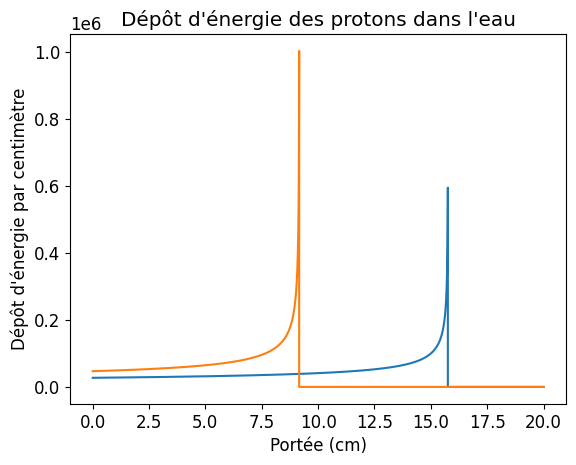

In [164]:
T_min = 3
T_max = 150
n_T = 5000
T = np.linspace(T_max, T_min, n_T)
range_max = 20 # cm

ranges_proton = np.zeros(n_T + 1) # 2 points added to pad with zeros after the peak
energy_drops = np.zeros(n_T + 1)

ranges_proton_bone = np.zeros(n_T + 1) # 2 points added to pad with zeros after the peak
energy_drops_bone = np.zeros(n_T + 1)

dT = np.ptp(T)

current_range = 0
current_range_bone = 0

for i in range(len(T) - 1):
    x, S = stopping_power_array(T[i+1], T[i], 500, liquid_water_ne, liquid_water_I)
    range_proton = trapezoidal_integration(x, S**-1)
    current_range += range_proton
    ranges_proton[i] = current_range # range in cm
    energy_drops[i] = dT/range_proton # energy drop

    # For Bone
    x, S = stopping_power_array(T[i+1], T[i], 500, compact_bone_ne, compact_bone_I)
    range_proton_bone = trapezoidal_integration(x, S**-1)
    current_range_bone += range_proton_bone
    ranges_proton_bone[i] = current_range_bone # range in cm
    energy_drops_bone[i] = dT/range_proton_bone # energy drop

# # extends the range array all the way to range_max with no energy drops
ranges_proton[-2] = current_range + 1e-6 # small increment for sharp peak
ranges_proton[-1] = range_max
energy_drops[-2:] = 0 # no energy drop after the peak

# # extends the range array all the way to range_max with no energy drops for bone
ranges_proton_bone[-2] = current_range_bone + 1e-6 # small increment for sharp peak
ranges_proton_bone[-1] = range_max
energy_drops_bone[-2:] = 0 # no energy drop after the peak

plt.plot(ranges_proton, energy_drops)
plt.plot(ranges_proton_bone, energy_drops_bone)
plt.xlabel("Portée (cm)")
plt.ylabel("Dépôt d'énergie par centimètre")
plt.title("Dépôt d'énergie des protons dans l'eau")

## Numéro 14

L'avantage de la protonthérapie est la possibilité de localiser les traitements avec grande précision. En effet, le pic de Bragg nous montre que la grande majorité de l'énergie (et donc des dommages) est déposée dans un intervalle de portée assez restreint (le "pic"), ce qui permet de cibler spécifiquement la tumeur cancéreuse en ajustant l'énergie initiale du proton. [1] Ainsi, l'on évite autant que possible de causer du dommage aux cellules en santé autour de la tumeur cancéreuse. Plusieurs méthodes existent afin de profiter au maximum du pic de Bragg: l'on parle ici par exemple de l'utilisation simultanée de plusieurs faisceaux de protons provenant d'endroits différents afin de limiter les dommages collatéraux et concentrer plusieurs pics de bragg au même endroit sur la tumeur. [1]

En comparaison, les photons déposent leur énergie sur une grande plage de portée, ce qui cause du dommages aux tissus en santé et ne permet donc pas de cibler des endroits spécifiques. [2] Du côté des électrons, leur pénétration des tissus est très faible vu leur petite masse, et ils déposent leur énergie presque également sur la totalité de la distance parcourue, ce qui rend leur utilisation peu pratique. [2]

## Numéro 15

En protonthérapie, les tumeurs que l'on traite ont une taille minimum de l'ordre de quelques millimètres. La largeur du pic de bragg, qui est utilisé afin de concentrer les dommages sur la tumeur, est également au minimum de l'ordre de quelques millimètres. L'erreur machine, dans notre cas, est largement plus petite que cela, et donc il n'est pas nécessaire de calculer les portées jusqu'à la précision machine en protonthérapie.

## Numéro 16

Tel que mentionné au numéro 14, relativement aux protons, les photons déposent leur énergie de manière également distribuée [2] le long de leur parcours. Par contre, les protons, avec le pic de Bragg, causent le dommage de manière locale [1]. Un mélanome oculaire a une taille de l'ordre des millimètres [3], et il est très important de ne pas causer de dommage au reste du tissu puisque l'oeil est un organe extrêmement sensible. L'utilisation de la protonthérapie va donc de soit puisqu'elle permet de concentrer les dommages sur le mélanome et d'épargner en grande majorité le reste de l'oeil.

## Numéro 17

Non, ce n'est pas réaliste. Puisque le proton est une particule chargée, il y aura des déviations le long de son parcours dû aux interactions avec les autres particules de la matière (dans le style Rutherford Backscaterring). Toutefois,  en pratique, ces déviations sont d'habitude mineures et ne concernent qu'une très mince proportion des protons: on parle de $1/10^4$ protons [1] qui seront déviés de manière significative, environ. Notre modèle peut donc être considéré une bonne approximation de la réalité, même si en réalité les protons ne se déplacent pas en ligne droite. 

# Bibliographie

[1] Rolf Jonas Persson, Kjerne- og strålingsfysikk, NTNU (https://www.ntnu.no/studier/emner/TFY4225#tab=omEmnet)
[2] https://en.wikipedia.org/wiki/Electron_therapy (voir graphique Dose / Depth)
[3] https://sante.journaldesfemmes.fr/fiches-maladies/2650893-melanome-uveal-oculaire-cause-symptomes-operation-pronostic-traitement/